In [1]:
import sys
sys.path.append('src')

In [2]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import math
import h5py


In [3]:

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import Dropout
from scipy.signal import savgol_filter
from keras.optimizers import Adam
import scipy.stats as stats


In [4]:

from energiapy.components.result import Result
from ppopt.plot import parametric_plot
from ppopt.mp_solvers.solve_mpqp import solve_mpqp, mpqp_algorithm
from ppopt.mplp_program import MPLP_Program
from ppopt.mpqp_program import MPQP_Program
import sympy
from energiapy.model.solve import solve
from energiapy.plot.plot_results import CostY, CostX
from energiapy.plot import plot_results, plot_scenario
from energiapy.model.formulate import formulate, Constraints, Objective, ModelClass
from energiapy.components.scenario import Scenario
from energiapy.components.location import Location
from energiapy.components.process import Process, VaryingProcess
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.material import Material
from energiapy.components.temporal_scale import TemporalScale
from energiapy.conversion.photovoltaic import solar_power_output
from energiapy.conversion.windmill import wind_power_output
from energiapy.utils.math_utils import normalize, min_max
from itertools import product
from matplotlib import rc

In [6]:
df = pandas.read_csv('ercot.csv')
df['Datetime'] = pandas.to_datetime(df['Unnamed: 0'])
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index('Datetime')
df = df.resample('D').mean()
df

C:\Users\cacodcar\AppData\Local\Temp\ipykernel_20484\105507789.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Datetime'] = pandas.to_datetime(df['Unnamed: 0'])


,COAST
Datetime,
2016-01-01,9733.736857
2016-01-02,9967.949162
2016-01-03,9409.771088
2016-01-04,10257.882329
2016-01-05,10532.679773
...,...
2020-12-27,10252.197429
2020-12-28,10735.672388
2020-12-29,10741.396777


<Axes: xlabel='Datetime'>

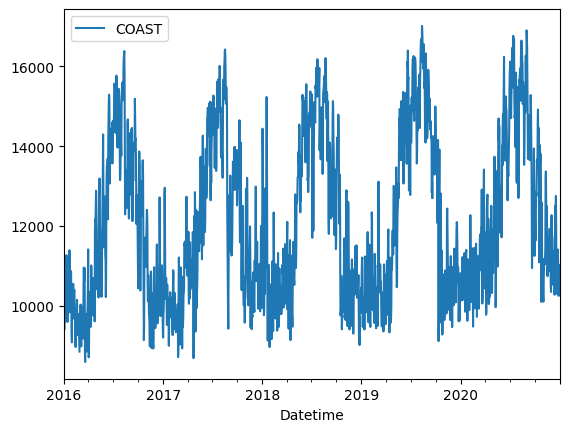

In [7]:
df.plot()

<Axes: xlabel='Datetime'>

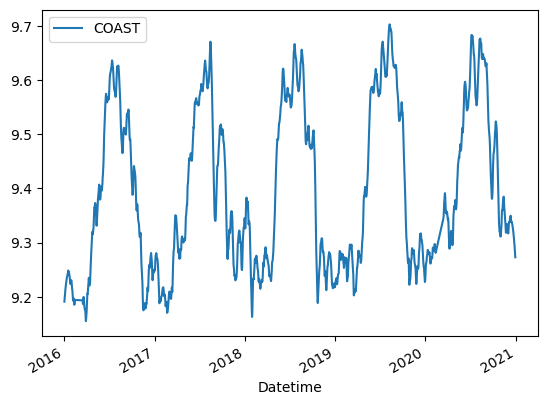

In [8]:
window_size = 30
polynomial_degree = 2
smoothed_data = savgol_filter(df['COAST'], window_size, polynomial_degree)
filtered_data = pandas.DataFrame({'COAST': smoothed_data}, index=df.index)
filtered_data['COAST'] = np.log(filtered_data['COAST'])
filtered_data = filtered_data.dropna()
filtered_data.plot()

In [9]:
 # convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

data = filtered_data.values
dataset=data.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

look_back = 150
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

learning_rate = 0.0005
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back)))
model.add(Dropout(0.10))
model.add(Dense(1))
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mse', optimizer=optimizer)

history = model.fit(trainX, trainY, epochs=500, batch_size=240, verbose=1, validation_data=(testX, testY))


Epoch 1/500

5/5 [==============================] - 3s 120ms/step - loss: 0.1302 - val_loss: 0.0826
Epoch 2/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0677 - val_loss: 0.0195
Epoch 3/500
5/5 [==============================] - 0s 13ms/step - loss: 0.0247 - val_loss: 0.0311
Epoch 4/500
5/5 [==============================] - 0s 13ms/step - loss: 0.0205 - val_loss: 0.0205
Epoch 5/500
5/5 [==============================] - 0s 13ms/step - loss: 0.0183 - val_loss: 0.0153
Epoch 6/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0153 - val_loss: 0.0151
Epoch 7/500
5/5 [==============================] - 0s 13ms/step - loss: 0.0118 - val_loss: 0.0148
Epoch 8/500
5/5 [==============================] - 0s 13ms/step - loss: 0.0105 - val_loss: 0.0078
Epoch 9/500
5/5 [==============================] - 0s 13ms/step - loss: 0.0106 - val_loss: 0.0073
Epoch 10/500
5/5 [==============================] - 0s 13ms/step - loss: 0.0100 - val_loss: 0.0106
Epoch 11/500
5/5

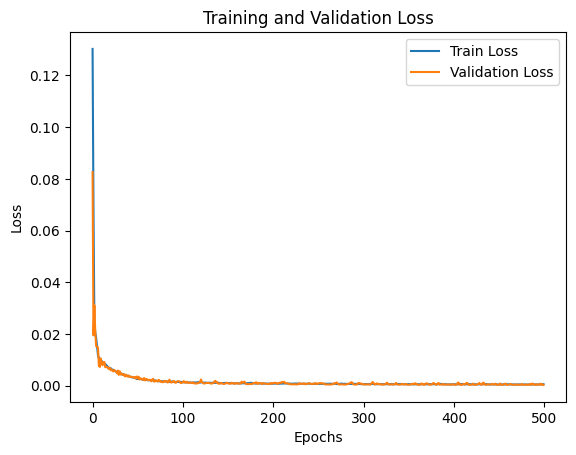

In [10]:
# Extract loss values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training loss and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

12/12 [==============================] - 0s 1ms/step
Train Score: 105.75 RMSE
Test Score: 124.16 RMSE
testPredictions:
[[10785.217 ]
 [10740.669 ]
 [10646.794 ]
 [10557.846 ]
 [10524.039 ]
 [10506.57  ]
 [10460.241 ]
 [10375.85  ]
 [10289.471 ]
 [10234.04  ]
 [10201.339 ]
 [10222.687 ]
 [10287.714 ]
 [10400.448 ]
 [10482.54  ]
 [10529.45  ]
 [10520.778 ]
 [10486.83  ]
 [10474.236 ]
 [10499.458 ]
 [10566.348 ]
 [10638.866 ]
 [10700.091 ]
 [10777.998 ]
 [10900.492 ]
 [11049.228 ]
 [11134.891 ]
 [11138.862 ]
 [11124.5625]
 [11097.806 ]
 [11027.857 ]
 [10969.862 ]
 [10956.814 ]
 [10937.292 ]
 [10877.459 ]
 [10791.45  ]
 [10698.928 ]
 [10617.075 ]
 [10535.939 ]
 [10459.014 ]
 [10390.    ]
 [10348.95  ]
 [10284.006 ]
 [10199.402 ]
 [10153.838 ]
 [10153.149 ]
 [10199.9375]
 [10301.773 ]
 [10404.853 ]
 [10492.172 ]
 [10545.026 ]
 [10583.553 ]
 [10621.308 ]
 [10682.614 ]
 [10713.345 ]
 [10718.147 ]
 [10711.903 ]
 [10730.901 ]
 [10725.826 ]
 [10716.768 ]
 [10718.443 ]
 [10717.146 ]
 [10694.307 ]

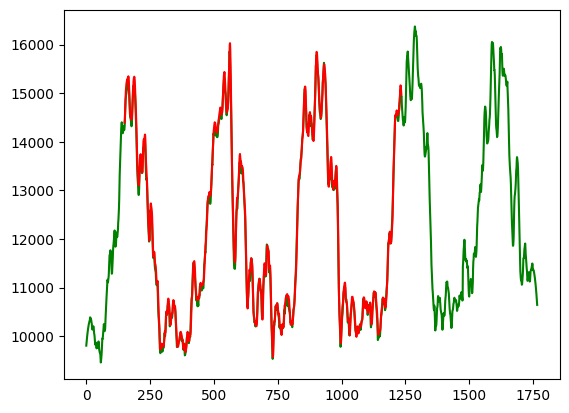

In [11]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainPredict = np.exp(trainPredict)
trainY = scaler.inverse_transform([trainY])
trainY = np.exp(trainY)
testPredict = scaler.inverse_transform(testPredict)
testPredict = np.exp(testPredict)
testY = scaler.inverse_transform([testY])
testY = np.exp(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(np.exp(scaler.inverse_transform(dataset)), color = 'green')
plt.plot(trainPredictPlot, color = 'red')

print('testPredictions:')
print(testPredict)

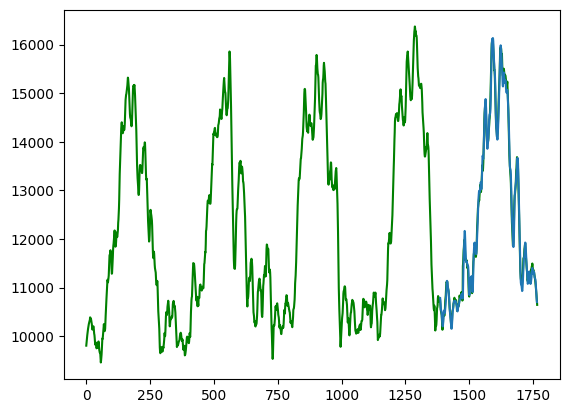

In [12]:
plt.plot(np.exp(scaler.inverse_transform(dataset)), color = 'green')
plt.plot(testPredictPlot)
plt.show()

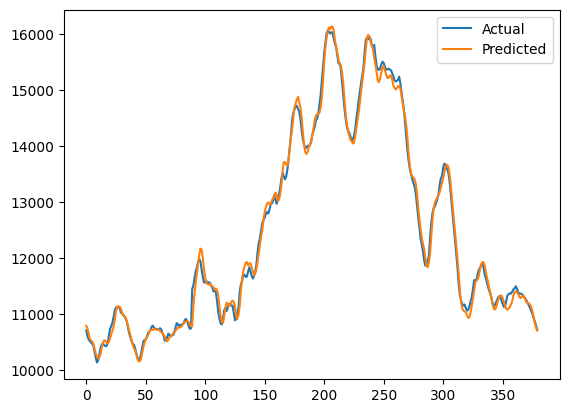

In [13]:
plt.plot(testY.flatten(), label='Actual')
plt.plot(testPredict, label='Predicted')
plt.legend()
plt.show()

In [14]:
rmse = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('RMSE:', rmse)
mape = np.mean(np.abs((testY[0] -testPredict[:,0]) / testY[0])) * 100
print('MAPE:', mape)
r2 = r2_score(testY[0], testPredict[:,0])
print('R-squared:', r2)

def mda(actual, predicted):
    actual_direction = np.sign(np.diff(actual))
    predicted_direction = np.sign(np.diff(predicted))
    correct_directions = np.sum(actual_direction == predicted_direction)
    mda_value = correct_directions / (len(actual_direction) - 1)
    return mda_value

mda_value = mda(testY[0], testPredict[:,0])
print('MDA:', mda_value)

RMSE: 124.1612669082163
MAPE: 0.7619384633369666
R-squared: 0.9950002456617842
MDA: 0.7804232804232805


In [15]:
# Prepare input for predicting future values
last_sequence = dataset[-look_back:]
num_predictions = 30

predicted_values = []

for _ in range(num_predictions):
    last_sequence_reshaped = np.reshape(last_sequence, (1, 1, look_back))
    predicted_value = model.predict(last_sequence_reshaped)
    predicted_values.append(predicted_value[0, 0])
    last_sequence = np.append(last_sequence[1:], predicted_value[0])

# Invert the predictions back to the original scale
predicted_values = np.exp(scaler.inverse_transform([predicted_values]))
# Print the predicted values
print(predicted_values)

1/1 [==============================] - 0s 20ms/step
[[10642.47142159 10624.33952234 10588.63442219 10557.3008037
  10523.44896968 10509.76533628 10510.67505437 10519.83254682
  10512.85357746 10481.83322843 10459.46297693 10449.61625518
  10451.14249845 10467.0124957  10479.74122763 10480.49517021
  10462.35325084 10456.9106983  10468.43097947 10494.34888464
  10538.69160094 10593.08796948 10637.24227358 10674.7072506
  10700.00324047 10739.49749944 10795.54168115 10852.79166859
  10911.3043676  10937.07573601]]


In [16]:
start_date = pandas.to_datetime(df.index[-1]) + pandas.DateOffset(days=1)  # Assuming the last date in df is the latest date
end_date = start_date + pandas.DateOffset(days=num_predictions-1)
future_dates = pandas.date_range(start=start_date, end=end_date)
predicted_values = np.reshape(predicted_values, (num_predictions,))
predicted_df = pandas.DataFrame(predicted_values, index=future_dates, columns=['Predicted'])
predicted_df

,Predicted
2021-01-01,10642.471422
2021-01-02,10624.339522
2021-01-03,10588.634422
2021-01-04,10557.300804
2021-01-05,10523.448970
2021-01-06,10509.765336
2021-01-07,10510.675054
2021-01-08,10519.832547
2021-01-09,10512.853577
2021-01-10,10481.833228


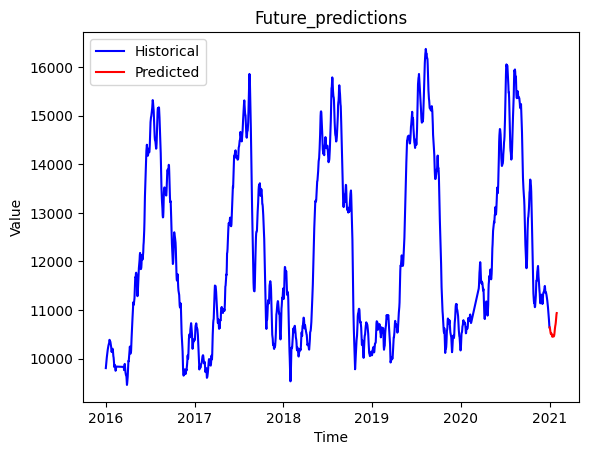

In [17]:
plt.plot(filtered_data.index, np.exp(filtered_data), color='blue', label='Historical')
plt.plot(predicted_df.index, predicted_df['Predicted'], color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Future_predictions')
plt.legend()
plt.show()

In [18]:
#model.save('C:\\Users\\Dell\\Desktop\\demand.h5')

In [19]:
def calculate_confidence_interval(predictions, standard_error, confidence_level=0.95):
    """Calculates the confidence interval for a given set of predictions.

    Args:
      predictions: A list of predictions.
      standard_error: The standard error of the predictions.
      confidence_level: The desired confidence level.

    Returns:
      A list of confidence intervals, where each confidence interval is a tuple of
      (lower bound, upper bound).
    """

    z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)
    confidence_intervals = []

    for prediction in predictions:
        lower_bound = prediction - z_score * standard_error
        upper_bound = prediction + z_score * standard_error
        confidence_intervals.append((lower_bound, upper_bound))

    return confidence_intervals

def create_confidence_intervals_df(confidence_intervals, predicted_df):
    """
    Create a DataFrame from confidence intervals.

    Parameters:
    - confidence_intervals (list or array-like): The confidence intervals data.
    - predicted_df (DataFrame): The DataFrame with suitable index.

    Returns:
    - DataFrame: The resulting DataFrame with columns 'lower_bound' and 'upper_bound'.
    """
    dt = pandas.DataFrame(confidence_intervals, columns=['lower_bound', 'upper_bound'])
    dt.index = predicted_df.index
    return dt

In [20]:
std_p = np.std(predicted_values)
std_error = std_p/np.sqrt(num_predictions)
ci_95 = calculate_confidence_interval(predicted_df['Predicted'],std_error, 0.95)
ci_99 = calculate_confidence_interval(predicted_df['Predicted'],std_error, 0.99)
ci_90 = calculate_confidence_interval(predicted_df['Predicted'],std_error, 0.90)
ci_85 = calculate_confidence_interval(predicted_df['Predicted'],std_error, 0.85)

In [21]:
ci_95 = create_confidence_intervals_df(ci_95, predicted_df)
ci_99 = create_confidence_intervals_df(ci_99, predicted_df)
ci_90 = create_confidence_intervals_df(ci_90, predicted_df)
ci_85 = create_confidence_intervals_df(ci_85, predicted_df)

In [22]:
max_ = max(ci_99['upper_bound'])
predicted_df['Predicted'] = predicted_df['Predicted']/max_
ci_99 = ci_99/max_
ci_95 = ci_95/max_
ci_90 = ci_90/max_
ci_85 = ci_85/max_

In [23]:
# plt.plot(predicted_df.index, predicted_df['Predicted'], color='red', label='Predicted')
# plt.fill_between(dt.index, dt['lower_bound'], dt['upper_bound'], color='blue', alpha=0.5, label='95% Confidence Interval')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('Future_predictions')
# plt.legend()
# plt.show()

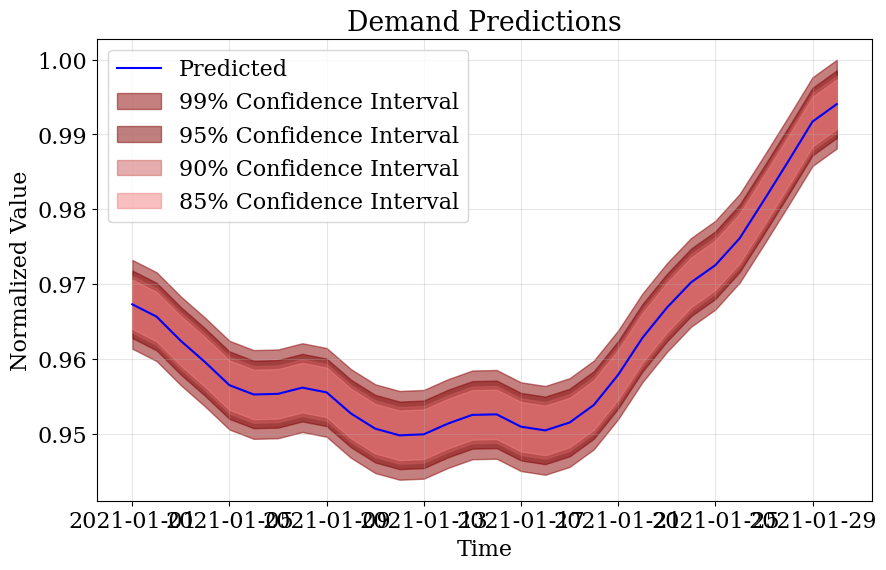

In [24]:
rc('font', **{'family': 'serif',
    'serif': ['Computer Modern'], 'size': 16})
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(predicted_df.index, predicted_df['Predicted'], color='blue', label='Predicted')
ax.fill_between(ci_99.index, ci_99['lower_bound'], ci_99['upper_bound'], color='darkred', alpha=0.5, label='99% Confidence Interval')
ax.fill_between(ci_95.index, ci_95['lower_bound'], ci_95['upper_bound'], color='maroon', alpha=0.5, label='95% Confidence Interval')
ax.fill_between(ci_90.index, ci_90['lower_bound'], ci_90['upper_bound'], color='indianred', alpha=0.5, label='90% Confidence Interval')
ax.fill_between(ci_85.index, ci_85['lower_bound'], ci_85['upper_bound'], color='lightcoral', alpha=0.5, label='85% Confidence Interval')

# xtick_positions = np.linspace(0, 30, 30)

# plt.xticks(predicted_df.index, list(range(30)), rotation = 45)
plt.legend()
plt.title(f'Demand Predictions')
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.grid(alpha=0.3)
plt.rcdefaults()

In [25]:
# def problem(demand_ci, index_):
#     scales = TemporalScale(discretization_list=[1])
    
#     Solar = Resource(name='Solar', cons_max=100, basis='MW', label='Solar Power')

#     Wind = Resource(name='Wind', cons_max=100, basis='MW', label='Wind Power')

#     Power = Resource(name='Power', basis='MW', label='Power generated', demand = True, varying = [VaryingResource.UNCERTAIN_DEMAND], 
#                     varying_bounds  = (demand_ci['lower_bound'][index_],demand_ci['upper_bound'][index_]))#(min(demand['COAST']), 1))
    
#     H2O = Resource(name='H2O', cons_max=500, basis='tons', label='Water')

#     O2 = Resource(name='O2', sell=True, basis='tons', label='Oxygen')

#     H2 = Resource(name='H2', basis='tons', label='Hydrogen', demand= True) #, varying = [VaryingResource.UNCERTAIN_DEMAND], varying_bounds  = (0.6, 0.8))

#     Uranium = Resource(name='Uranium', cons_max=1000,
#                    price=42.70/(250/2), basis='kg', label='Uranium')
    
#     LiI = Process(name='LiI', storage=Power, vopex=1302, capex=0, fopex=0,  prod_max=100,
#                 storage_loss=0.11,  label='Lithium-ion battery', basis='MW', store_max=30)

#     WF = Process(name='WF', conversion={Wind: -1, Power: 0.85}, vopex=990, capex=0, fopex=0,
#                 prod_max=100, label='Wind mill array', basis='MW')#, varying = [VaryingProcess.UNCERTAIN_CAPACITY], 
#                 #varying_bounds = (wind_ci['lower_bound'][index_],wind_ci['upper_bound'][index_]))

#     PV = Process(name='PV', conversion={Solar: -1, Power: 0.75}, vopex=567, capex=0, fopex=0,
#                 prod_max=100, label='Solar PV', basis='MW')#, varying = [VaryingProcess.UNCERTAIN_CAPACITY], 
#                 # varying_bounds = (solar_ci['lower_bound'][index_],solar_ci['upper_bound'][index_]))

#     PEM = Process(name='PEM', conversion={Power: -1, H2: 0.3537, H2O: -3.1839}, capex=0, fopex=0,
#               vopex=1.55*10**3, prod_max=100, cap_min = 0, basis = 'tons', label = 'PEM' )
    
#     ASMR = Process(name='ASMR', conversion={Uranium: -4.17*10**(-5), H2O: -3.364, Power: 1},
#                capex=7988951, fopex=0.04*0.730, vopex=7988, prod_max=100, label='Small modular reactors (SMRs)', block='power_gen')
    
#     region = Location(name='region', processes={
#                     LiI, WF, ASMR}, scales=scales, label='some region wo dispatchable')
#     scenario = Scenario(name='example', demand={region: {Power:100}}, network=region, scales=scales, label='example scenario')
#     matrix = formulate(scenario=scenario, model_class=ModelClass.MPLP)
#     # print(matrix)
#     # return matrix
#     # print(scenario.b_df)
#     print(matrix['no_eq_cons'])
#     return matrix, solve(matrix = matrix, interface = 'native', name = 'results', solver = 'ppopt') 


In [26]:
# time_periods = 3
# solution_99 =  [problem(ci_99, index_) for index_ in range(time_periods)]
# solution_95 =  [problem(ci_95, index_) for index_ in range(time_periods)]
# solution_90 =  [problem(ci_90, index_) for index_ in range(time_periods)]
# solution_85 =  [problem(ci_85, index_) for index_ in range(time_periods)]

In [27]:
scales = TemporalScale(discretization_list=[1])

Solar = Resource(name='Solar', cons_max=100, basis='MW', label='Solar Power')

Wind = Resource(name='Wind', cons_max=100, basis='MW', label='Wind Power')

Power = Resource(name='Power', basis='MW', label='Power generated', demand = True, varying = [VaryingResource.UNCERTAIN_DEMAND], 
                 varying_bounds  = (ci_95['lower_bound'][1],ci_95['upper_bound'][1]))#(min(demand['COAST']), 1))

H2O = Resource(name='H2O', cons_max=500, basis='tons', label='Water')

O2 = Resource(name='O2', sell=True, basis='tons', label='Oxygen')

H2 = Resource(name='H2', basis='tons', label='Hydrogen', demand= True) #, varying = [VaryingResource.UNCERTAIN_DEMAND], varying_bounds  = (0.6, 0.8))

Uranium = Resource(name='Uranium', cons_max=1000,
                price=42.70/(250/2), basis='kg', label='Uranium')

LiI = Process(name='LiI', storage=Power, vopex=1302, capex=0, fopex=0,  prod_max=200,
            storage_loss=0.11,  label='Lithium-ion battery', basis='MW', store_max=200)

WF = Process(name='WF', conversion={Wind: -1, Power: 0.85}, vopex=990, capex=0, fopex=0,
            prod_max=100, label='Wind mill array', basis='MW')#, varying = [VaryingProcess.UNCERTAIN_CAPACITY], 
            #varying_bounds = (0,1))

PV = Process(name='PV', conversion={Solar: -1, Power: 0.75}, vopex=567, capex=0, fopex=0,
            prod_max=100, label='Solar PV', basis='MW')#, varying = [VaryingProcess.UNCERTAIN_CAPACITY], 
            # varying_bounds = (solar_ci['lower_bound'][index_],solar_ci['upper_bound'][index_]))

PEM = Process(name='PEM', conversion={Power: -1, H2: 0.3537, H2O: -3.1839}, capex=0, fopex=0,
            vopex=1.55*10**3, prod_max=100, cap_min = 0, basis = 'tons', label = 'PEM' )

ASMR = Process(name='ASMR', conversion={Uranium: -4.17*10**(-5), H2O: -3.364, Power: 1},
            capex=7988951, fopex=0.04*0.730, vopex=7988, prod_max=100, label='Small modular reactors (SMRs)', block='power_gen')

region = Location(name='region', processes={
                LiI, WF, ASMR}, scales=scales, label='some region wo dispatchable')
scenario = Scenario(name='example', demand={region: {Power:60}}, network=region, scales=scales, label='example scenario')
matrix = formulate(scenario=scenario, model_class=ModelClass.MPLP)
# print(matrix)
# return matrix
# print(scenario.b_df)

The problem has the following variables:
Resource inventory level (Inv) x 1
Exact resource discharge (Sf) x 1
Uncertain resource discharge (S) x 1
Exact resource availability (Af) x 3
Uncertain resource availability (A) x 0
Exact resource price (Cf) x 3
Uncertain resource price (C) x 0
Exact process production (Pf) x 4
Uncertain process production (P) x 0
 For a total of 10 (9 fixed, and 1 uncertain)


ValueError: Length mismatch: Expected axis has 26 elements, new values have 25 elements

In [ ]:
prog = MPLP_Program(matrix['A'], matrix['b'], matrix['c'], matrix['H'],
                    matrix['CRa'], matrix['CRb'], matrix['F'], equality_indices=list(range(matrix['no_eq_cons'])))

In [128]:
matrix['A'][0][6] = -1 
matrix['A'][0][7] = 1 

In [129]:
scenario.c_df

,0
Inv_LiI_Power_stored,0.0000
S_Power,0.0000
Af_H2O,0.0000
Af_Uranium,0.3416
Af_Wind,0.0000
Pf_ASMR,7988.0000
Pf_LiI,1302.0000
Pf_LiI_discharge,0.0000
Pf_WF,990.0000


In [130]:
scenario.make_conversion_df()

,Uranium,LiI_Power_stored,Wind,Power,H2O
LiI_discharge,0.000000,-1.0,0.0,0.89,0.000
ASMR,-0.000042,0.0,0.0,1.00,-3.364
WF,0.000000,0.0,-1.0,0.85,0.000
LiI,0.000000,1.0,0.0,-1.00,0.000


In [131]:
scenario.A_df

,Inv_LiI_Power_stored,S_Power,Af_H2O,Af_Uranium,Af_Wind,Pf_ASMR,Pf_LiI,Pf_LiI_discharge,Pf_WF
MB_H2O(=),1.0,0.0,0.0,0.0,0.0,0.000000,-1.0,1.00,0.00
MB_LiI_Power_stored(=),0.0,-1.0,0.0,0.0,0.0,1.000000,-1.0,0.89,0.85
MB_Power(=),0.0,0.0,1.0,0.0,0.0,-3.364000,0.0,0.00,0.00
MB_Uranium(=),0.0,0.0,0.0,1.0,0.0,-0.000042,0.0,0.00,0.00
MB_Wind(=),0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.00,-1.00
Inv_LiI_Power_stored(<),1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00
S_Power(>),0.0,-1.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00
Af_H2O(<),0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.00,0.00
Af_Uranium(<),0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.00,0.00
Af_Wind(<),0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.00,0.00


In [132]:
prog.display_latex()

$$\min_{x}\left[\begin{matrix}0\\0\\0\\0.3416\\0\\7.988e+03\\1.302e+03\\0\\990.0\end{matrix}\right]^T\left[\begin{matrix}x_{0}\\x_{1}\\x_{2}\\x_{3}\\x_{4}\\x_{5}\\x_{6}\\x_{7}\\x_{8}\end{matrix}\right]$$
$$\left[\begin{matrix}1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & -1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 1.0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 1.0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 1.0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 1.0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 1.0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 1.0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1.0\\-1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & -1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & -1.0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & -1.0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & -1.0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & -1.0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & -1.0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & -1.0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -1.0\end{matrix}\right]\left[\begin{matrix}x_{0}\\x_{1}\\x_{2}\\x_{3}\\x_{4}\\x_{5}\\x_{6}\\x_{7}\\x_{8}

In [133]:
time_periods = 24

In [134]:
from scipy.linalg import block_diag
A = block_diag(*[matrix['A'] for x in range(time_periods)])

In [135]:
for i in range(time_periods -1):
    x_cord = i*9
    y_cord = (i+1)*(23)
    A[y_cord, x_cord] = -1

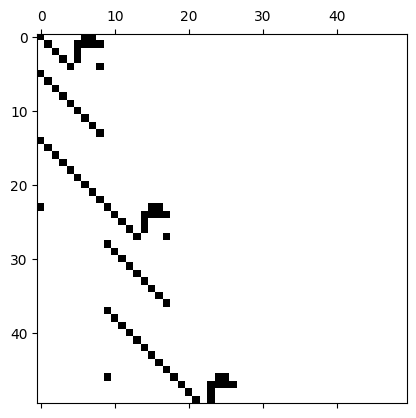

In [136]:
plt.spy(A[:50,:50])

In [137]:
c = np.vstack([matrix['c'] for _ in range(time_periods)])

In [138]:
F = np.vstack([matrix['F'] for _ in range(time_periods)])

In [139]:
b = np.vstack([matrix['b'] for _ in range(time_periods)])

In [140]:
for i in range(time_periods):
    b[23*i+13] = predicted_df.to_numpy()[i]*100

In [141]:
A_t = np.array([[1],[-1]])
b_t = np.array([[6],[0]])

In [142]:
eqs = [[0+i*23,1+i*23,2+i*23,3+i*23,4+i*23] for i in range(time_periods)]
eqs = sum(eqs, [])

In [143]:
from ppopt.mplp_program import MPLP_Program
from ppopt.mp_solvers.solve_mpqp import solve_mpqp, mpqp_algorithm

prog = MPLP_Program(A, b, c, np.zeros((1,time_periods*9)).T,
                    A_t, b_t, F, equality_indices=eqs)

In [144]:
prog.solver.solvers['lp'] = 'gurobi'
prog.b[0] = 20
prog.process_constraints()

In [145]:
for i in range(24):
    prog.c[0 + 9*i] = 0 * (1 - 0.0001)**i
    prog.c[1 + 9*i] = -10 * (1 - 0.0001)**i
    prog.c[2 + 9*i] = 10 * (1 - 0.0001)**i
    prog.c[3 + 9*i] = 10000 * (1 - 0.0001)**i
    # prog.c[4 + 9*i] = 0
    prog.c[5 + 9*i] = 100000 * (1 - 0.0001)**i
    prog.c[6 + 9*i] = 0 * (1 - 0.0001)**i
    prog.c[7 + 9*i] = 0 * (1 - 0.0001)**i
    prog.c[8 + 9*i] = 0 * (1 - 0.0001)**i

In [146]:
from ppopt.mp_solvers.solve_mpqp import solve_mpqp, mpqp_algorithm

In [147]:
prog.solve_theta(np.array([[3]])).active_set, prog.num_constraints()

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 124, 131, 135, 136, 139, 146, 150, 151, 154,
        161, 165, 166, 169, 176, 180, 181, 184, 191, 195, 196, 199, 206,
        210, 211, 214, 221, 225, 226, 229, 236, 240, 241, 244, 251, 255,
        256, 259, 266, 270, 271, 274, 281, 285, 286, 289, 296, 300, 301,
        304, 311, 315, 316, 319, 326, 330, 331, 334

In [148]:
prog.solve_theta(np.array([[0]])).active_set

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 124, 125, 127, 128, 130, 131, 139, 140, 142, 143,
       145, 146, 147, 154, 155, 157, 158, 160, 161, 162, 169, 170, 172,
       173, 175, 176, 177, 184, 185, 187, 188, 190, 191, 192, 199, 200,
       202, 203, 205, 206, 207, 214, 215, 217, 218, 220, 221, 222, 229,
       230, 232, 233, 235, 236, 237, 244, 245, 247, 248, 250, 25

In [149]:
from ppopt.utils.constraint_utilities import is_full_rank

is_full_rank(prog.A[prog.equality_indices])

True

In [150]:
theta = np.linspace(0.0001, 5.9999, 100)

In [151]:
sols = [prog.solve_theta(np.array([[t]])) for t in theta]
sols_obj = [sol.obj.flatten() for sol in sols if sol is not None]

In [152]:
#plt.plot(theta, sols_obj)

In [153]:
x = prog.solve_theta(np.array([[3]]))

In [154]:
count = 0
for index, i in enumerate(x.dual):
    if not np.isclose(i, 0):
        count += 1
print(count)

192


In [155]:
sol2 = prog.solve_theta(np.array([[2]]))
sol3 = prog.solve_theta(np.array([[3]]))

In [156]:
sol0 = prog.solve_theta(np.array([[0]]))

In [157]:
A = sol3.sol - sol2.sol
b = sol0.sol

In [158]:
A[:9]

array([ 1.40593723e+01,  6.00000000e+01,  2.43933198e+02,  3.02378548e-03,
        0.00000000e+00,  7.25128413e+01,  0.00000000e+00, -1.40593723e+01,
        0.00000000e+00])

In [159]:
prog.c.T@(b + A*6)

array([8.63200629e+08])

In [160]:
prog.c[:9]

array([[ 0.e+00],
       [-1.e+01],
       [ 1.e+01],
       [ 1.e+04],
       [ 0.e+00],
       [ 1.e+05],
       [ 0.e+00],
       [ 0.e+00],
       [ 0.e+00]])

In [61]:
sol3 = prog.solve_theta(np.array([[5.9]]))
# sol3 = prog.solve_theta(numpy.array([[0.1]]))


# time_sols = sol3.sol.reshape(24, -1)
# plt.subplots(figsize=(20, 10))
# labels = ['Inv','Sale of Power','Cons. H20','Cons. U','Cons. Wind','Prod. Nucluer','Prod. LiIon','Prod. LiIon Discharch','Prod. Windfarm']
# for i in range(9):
#     plt.plot(list(range(24)), time_sols[:,i])
# plt.legend(labels)
# plt.savefig('baba.pdf')

# plt.subplots(figsize=(20, 10))
time_sols = sol3.sol.reshape(24, -1)
labels = ['Inv Power','S Power','C H2O','C Ur','C Wind','P SMR','P LiI',r'P LiI$_d$','P WF']
lines = ['dotted', 'dashed', 'solid','solid', 'solid', 'dashdot', 'dashdot', 'dashdot', 'dashdot']
annot = ['', '', 'H2O', 'Ur', 'Wind', 'SMR', 'LiI', 'LiI_d', 'WF']
# for i in range(9):
#     plt.plot(list(range(24)), time_sols[:,i])
# plt.legend(labels)

# plt.savefig('baba_nominal.pdf')
from matplotlib import rc
rc('font', **{'family': 'serif',
    'serif': ['Computer Modern'], 'size': 16})
fig, ax = plt.subplots(figsize=(10,6))
# ax.scatter(normalize(obj3), normalize(obj4), s=10, color='steelblue')
for i in range(9):
    ax.plot(list(range(24)), time_sols[:,i], label=labels[i], linestyle = lines[i])
    # ax.annotate(annot[i], xy = (23, time_sols[:,i][23]))

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
      fancybox=True, shadow=True, ncol=5)

# ax = axis_formatter(axes=ax, xcord=x_, axis_labels='M')
# ax.set_xticklabels(list(range(24)))

# xtick_positions = np.linspace(0, 24, 24)

# plt.xticks(list(range(24)), list(range(24)), rotation = 45)
# plt.legend()
plt.title(f'Robust Schedule')
plt.xlabel("Hour")
plt.ylabel("Amount")
plt.grid(alpha=0.3)
plt.rcdefaults()
plt.tight_layout()
plt.savefig('baba_6.pdf')
plt.savefig('baba_6.png', dpi = 400)

AttributeError: 'NoneType' object has no attribute 'sol'

SolverOutput(obj=array([[2.38315844e+08]]), sol=array([1.40593723e+01, 1.80000000e+02, 3.20092853e+02, 3.96785730e-03,
       9.36004565e+01, 9.51524533e+01, 0.00000000e+00, 5.94062772e+00,
       9.36004565e+01, 1.32943197e+01, 1.80000000e+02, 3.36400000e+02,
       4.17000000e-03, 9.33165920e+01, 1.00000000e+02, 0.00000000e+00,
       7.65052544e-01, 9.33165920e+01, 1.22569849e+01, 1.80000000e+02,
       3.36400000e+02, 4.17000000e-03, 9.30314965e+01, 1.00000000e+02,
       0.00000000e+00, 1.03733483e+00, 9.30314965e+01, 1.09670582e+01,
       1.80000000e+02, 3.36400000e+02, 4.17000000e-03, 9.27670179e+01,
       1.00000000e+02, 0.00000000e+00, 1.28992675e+00, 9.27670179e+01,
       9.63422459e+00, 1.80000000e+02, 3.36400000e+02, 4.17000000e-03,
       9.27220919e+01, 1.00000000e+02, 0.00000000e+00, 1.33283357e+00,
       9.27220919e+01, 8.35097673e+00, 1.80000000e+02, 3.36400000e+02,
       4.17000000e-03, 9.27740111e+01, 1.00000000e+02, 0.00000000e+00,
       1.28324786e+00, 9.2774